# 52100865 - Lương Quang Vinh   
# 52100495 - Nguyễn Thanh Triều

Goal : Dùng mô hình Random-Forest để dự đoán bệnh tim 

# Import

In [158]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix

from collections import Counter
import imblearn
from imblearn.utils._validation import _check_X as check_X
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



In [159]:
df = pd.read_csv('heart_2022_no_nans_reduced.csv')
df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4,0,Within past year (anytime less than 12 months ...,Yes,9,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0,0,Within past year (anytime less than 12 months ...,Yes,6,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0,0,Within past year (anytime less than 12 months ...,No,8,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5,0,Within past year (anytime less than 12 months ...,Yes,9,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3,15,Within past year (anytime less than 12 months ...,Yes,5,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


# Explore the data


In [160]:
df.shape # Định dạng 

(5000, 40)

In [161]:
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,4.393400,4.163800,7.044600,1.709460,84.467474,28.829234
std,8.681481,8.190066,1.553928,0.105384,21.009122,6.470347
min,0.000000,0.000000,1.000000,1.220000,35.380000,12.940000
25%,0.000000,0.000000,6.000000,1.630000,69.850000,24.390000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.800000
75%,4.000000,4.000000,8.000000,1.780000,95.365000,32.080000
max,30.000000,30.000000,24.000000,2.160000,249.480000,91.550000


# Calculate the missing values


In [162]:
df.isna().sum().sort_values(ascending = False).head(40)


State                        0
Sex                          0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI                          0
AlcoholDrinkers              0
HIVTesting                   0
FluVaxLast12                 0
PneumoVaxEver                0
TetanusLast10Tdap            0
HighRiskLastYear             0
DifficultyConcentrating      0
BlindOrVisionDifficulty      0
DeafOrHardOfHearing          0
HadHeartAttack               0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadAngina                    0
HadDiabetes                  0
HadStrok

In [163]:
df.drop(columns = ['State', 'Sex'], inplace = True)

In [164]:
replacement_dict = {'Yes': 1, 'No': 0}
df['HadHeartAttack'] = df['HadHeartAttack'].replace(replacement_dict)
df['HadAngina'] = df['HadAngina'].replace(replacement_dict)
    
# Create a new column that will be our target column
df['HeartDisease'] = df['HadHeartAttack'] | df['HadAngina']

# Drop old columns
df.drop(columns = ['HadHeartAttack','HadAngina'], inplace = True)

df.shape

(5000, 37)

In [165]:
df.head(5)

,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadStroke,HadAsthma,HadSkinCancer,...,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HeartDisease
0,Very good,4,0,Within past year (anytime less than 12 months ...,Yes,9,None of them,No,No,No,...,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No,0
1,Very good,0,0,Within past year (anytime less than 12 months ...,Yes,6,None of them,No,No,No,...,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,0
2,Very good,0,0,Within past year (anytime less than 12 months ...,No,8,"6 or more, but not all",No,No,No,...,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,0
3,Fair,5,0,Within past year (anytime less than 12 months ...,Yes,9,None of them,No,No,Yes,...,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,0
4,Good,3,15,Within past year (anytime less than 12 months ...,Yes,5,1 to 5,No,No,No,...,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,0


# Numerical columns

In [166]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
print(df_num.shape)
df_num.head()

(5000, 7)


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,HeartDisease
0,4,0,9,1.60,71.67,27.99,0
1,0,0,6,1.78,95.25,30.13,0
2,0,0,8,1.85,108.86,31.66,0
3,5,0,9,1.70,90.72,31.32,0
4,3,15,5,1.55,79.38,33.07,0


# Draw histogram 

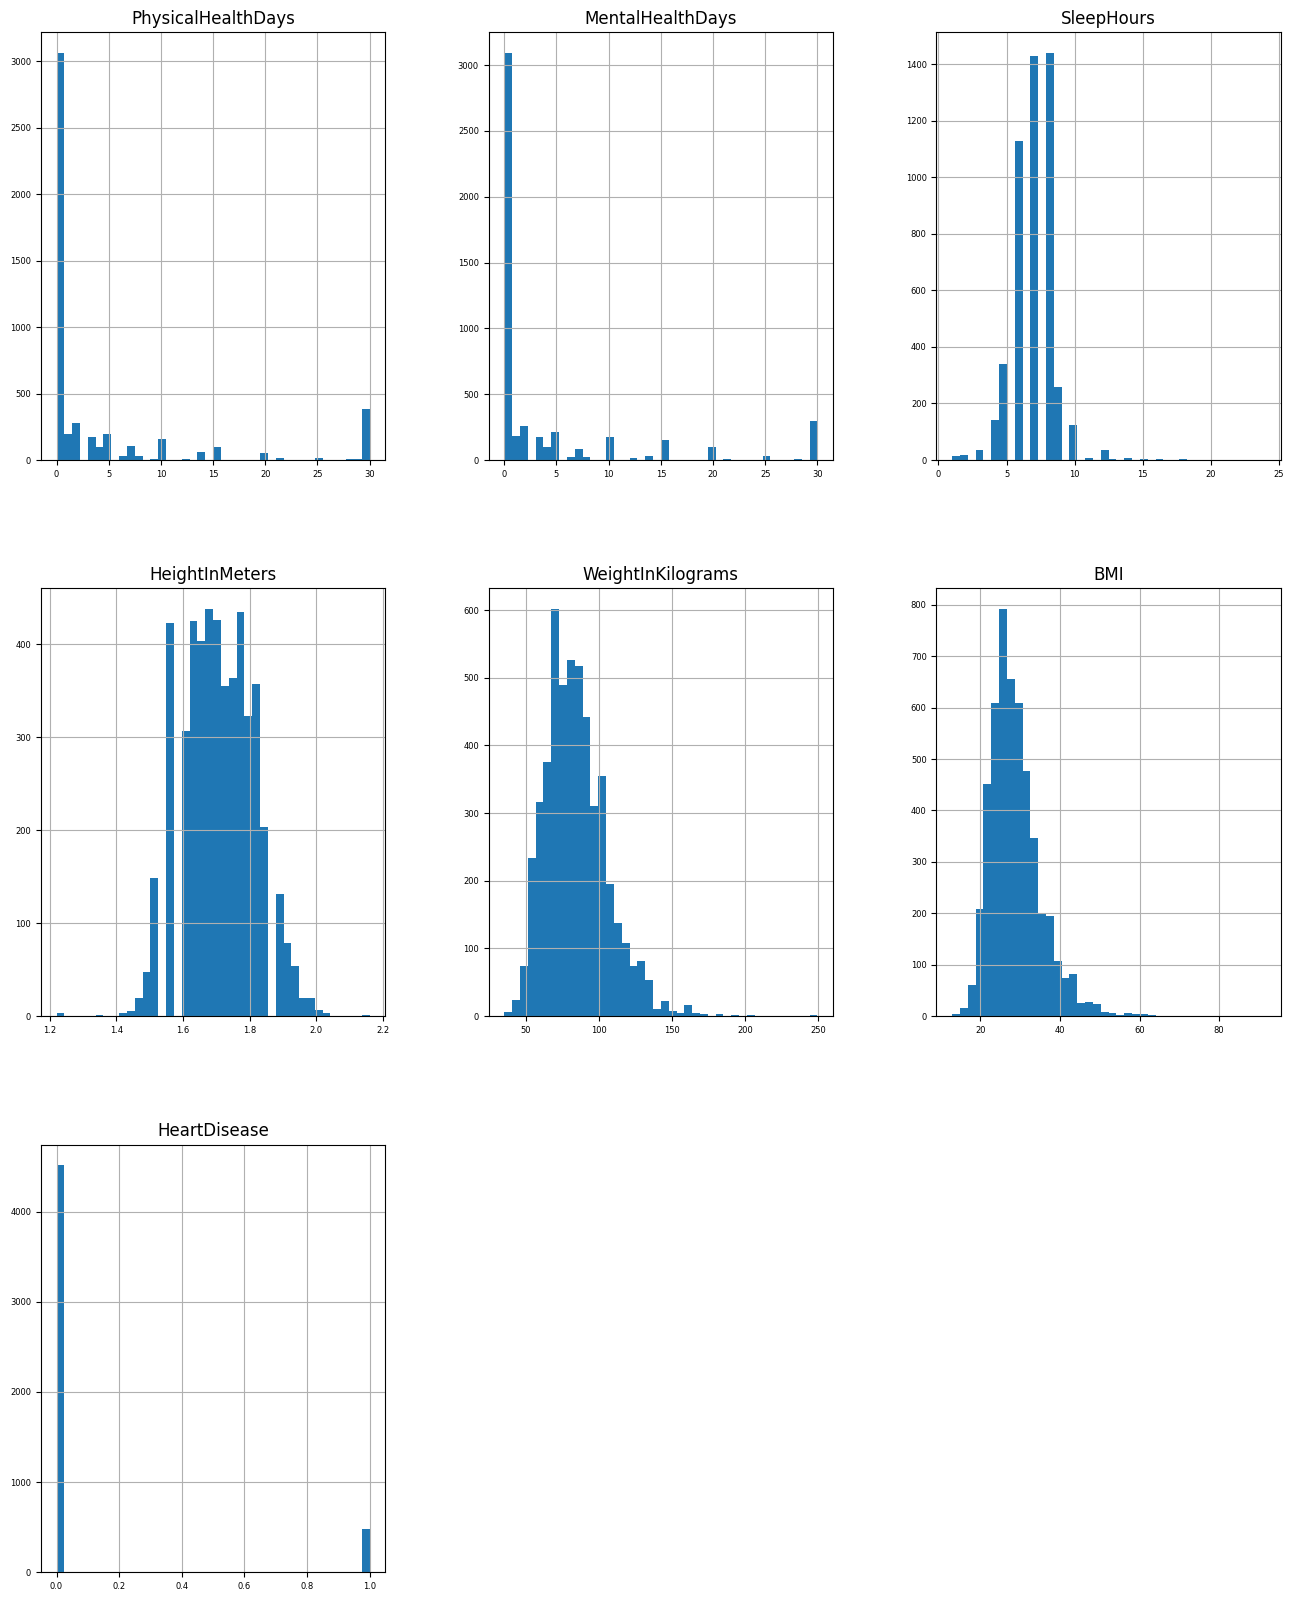

In [167]:
df_num.hist(figsize=(16, 20), bins=40, xlabelsize=6, ylabelsize=6);

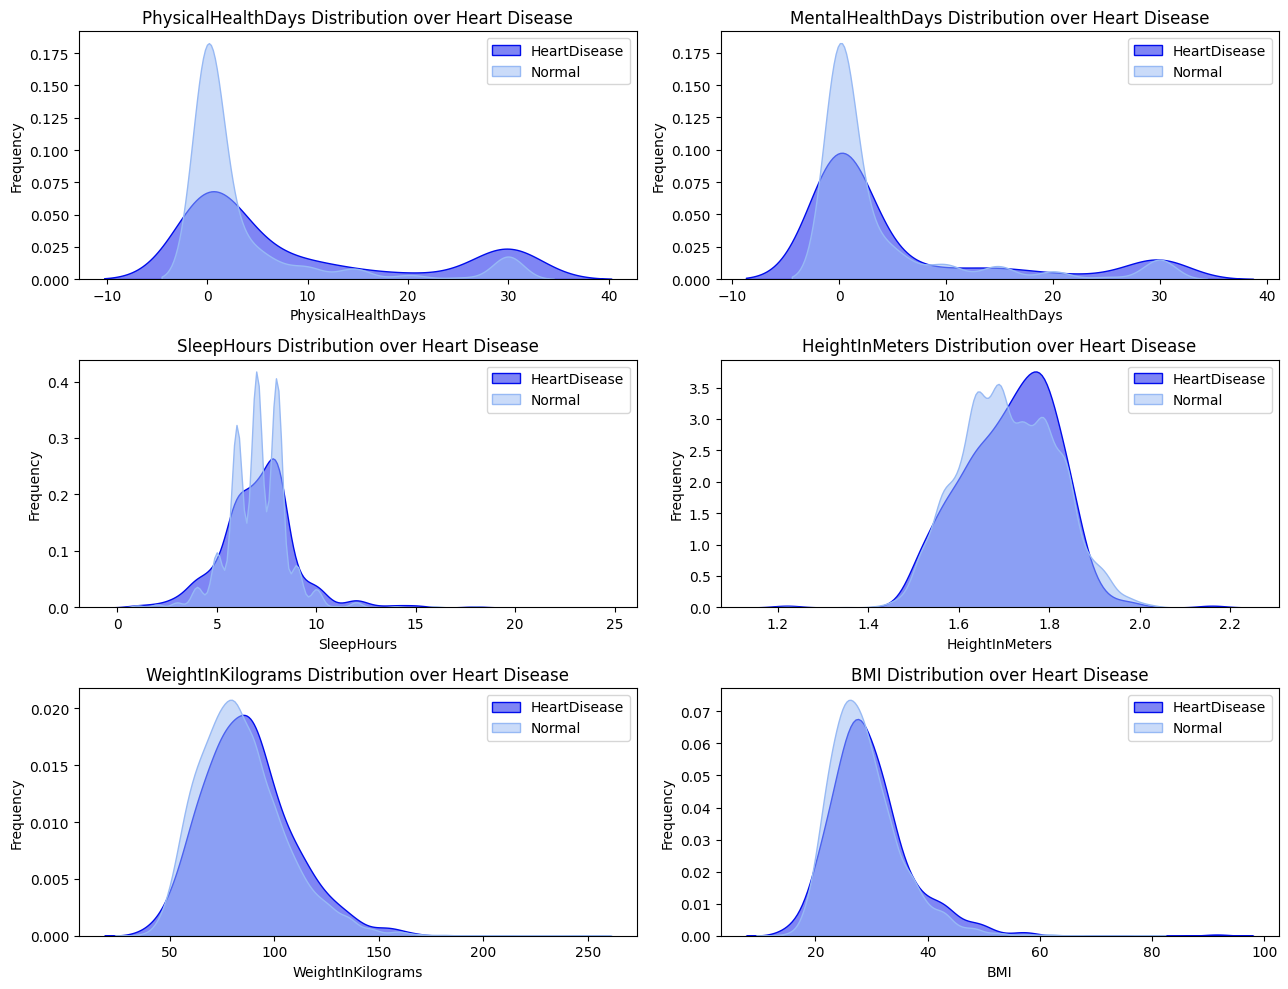

In [168]:
fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(13, 10))

for idx, column in enumerate(df_num.drop(columns = 'HeartDisease')):
    row_idx = idx // 2
    col_idx = idx % 2
    
    sns.kdeplot(df[df["HeartDisease"] == 1][column], alpha=0.5, fill=True, color="#000CEB", label="HeartDisease", ax=axes[row_idx, col_idx])
    sns.kdeplot(df[df["HeartDisease"] == 0][column], alpha=0.5, fill=True, color="#97B9F4", label="Normal", ax=axes[row_idx, col_idx])
    
    axes[row_idx, col_idx].set_xlabel(column)
    axes[row_idx, col_idx].set_ylabel("Frequency")
    axes[row_idx, col_idx].set_title(f"{column} Distribution over Heart Disease")
    axes[row_idx, col_idx].legend()

plt.tight_layout()
plt.show()

# Categorical columns

In [169]:
df_cat = df.select_dtypes('object')
df_cat.nunique().sort_values()
# Đếm giá trị duy nhất trong mỗi cột

DifficultyConcentrating       2
DifficultyErrands             2
DifficultyDressingBathing     2
DifficultyWalking             2
HighRiskLastYear              2
BlindOrVisionDifficulty       2
DeafOrHardOfHearing           2
HIVTesting                    2
HadArthritis                  2
HadKidneyDisease              2
HadDepressiveDisorder         2
HadCOPD                       2
HadSkinCancer                 2
HadAsthma                     2
HadStroke                     2
FluVaxLast12                  2
PhysicalActivities            2
PneumoVaxEver                 2
AlcoholDrinkers               2
ChestScan                     2
CovidPos                      3
SmokerStatus                  4
HadDiabetes                   4
RemovedTeeth                  4
LastCheckupTime               4
TetanusLast10Tdap             4
ECigaretteUsage               4
RaceEthnicityCategory         5
GeneralHealth                 5
AgeCategory                  13
dtype: int64

# Outlier

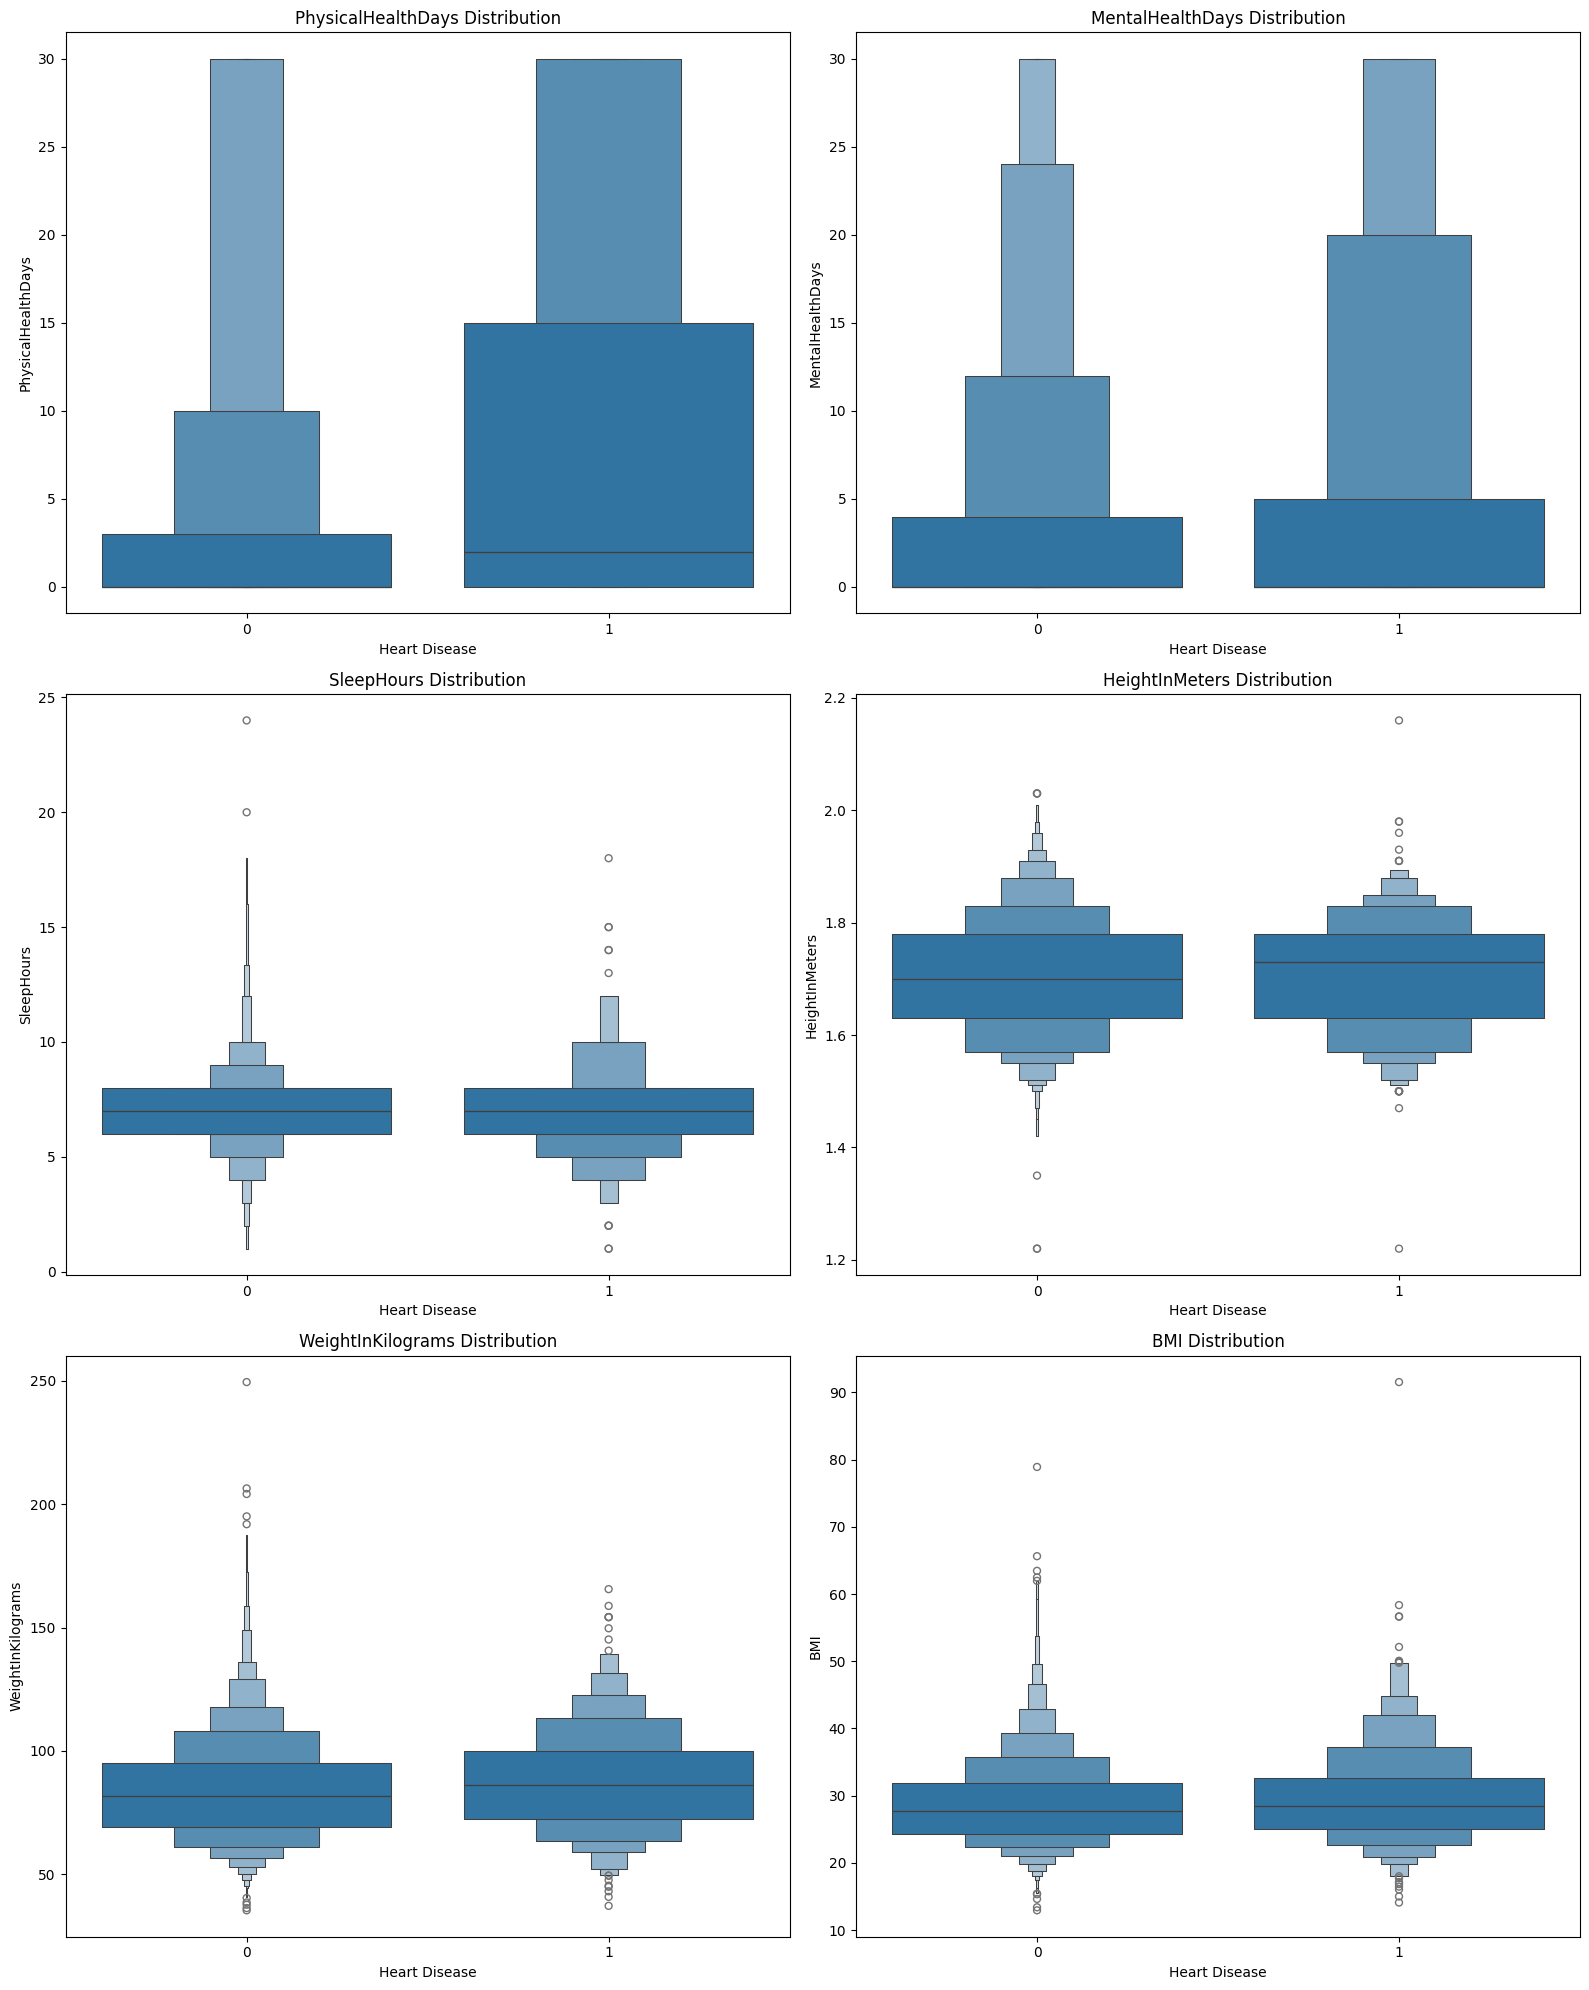

In [170]:
fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(16, 20))

for idx, column in enumerate(df_num.drop(columns = 'HeartDisease')):
    row_idx = idx // 2
    col_idx = idx % 2
    
    sns.boxenplot( x='HeartDisease' , y= column , data=df, ax=axes[row_idx, col_idx])
    
    axes[row_idx, col_idx].set_xlabel("Heart Disease")
    axes[row_idx, col_idx].set_ylabel(column)
    axes[row_idx, col_idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()

# Multicollinearity

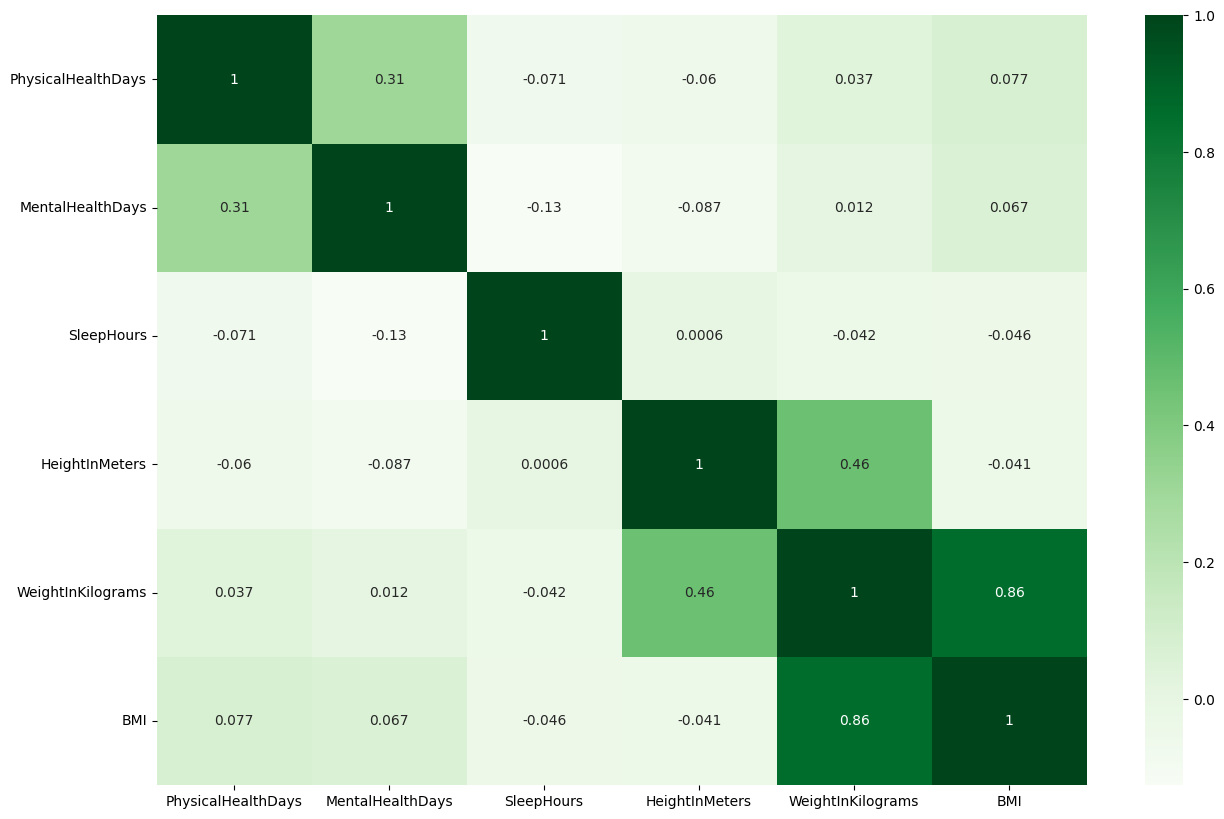

In [171]:
corr = df_num.drop(columns= 'HeartDisease').corr()
fig , ax = plt.subplots(figsize=(15 , 10))
sns.heatmap(corr ,annot= True , ax=ax , cmap= 'Greens');

# Minimize Multicollinearity 

In [172]:
# kiểm tra mối tương quan giữa các cột => WeightInKilograms & BMI 
print(f"WeightInKilograms and BMI :{df['WeightInKilograms'].corr(df['BMI'])}")

print(f"WeightInKilograms and the target :{df['WeightInKilograms'].corr(df['HeartDisease'])}")

print(f"BMI and the target :{df['BMI'].corr(df['HeartDisease'])}")

WeightInKilograms and BMI :0.8585910595689767
WeightInKilograms and the target :0.04259609960263705
BMI and the target :0.04489362389036299


In [173]:
# loại bỏ 'WeightInKilograms' column
df.drop(columns = 'WeightInKilograms', inplace = True)

# Encoding categorical data


In [174]:
dfc = df

In [175]:
df_categorical=df_cat.columns
df_categorical

Index(['GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
       'RemovedTeeth', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [176]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), df_categorical)],
    remainder='passthrough')

X_transformed = preprocessor.fit_transform(df.drop(columns = 'HeartDisease'))

# Splitting data for train and test



In [177]:
target = df['HeartDisease']

X_train , X_test , y_train , y_test = train_test_split(X_transformed ,target ,test_size=0.2 , random_state=42 )
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4000, 95)
y_train shape: (4000,)
X_test shape: (1000, 95)
y_test shape: (1000,)


## Feature Selection

In [188]:
# Import các thư viện cần thiết
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Áp dụng LabelEncoder cho từng cột
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        X_train[column] = le.fit_transform(X_train[column])
        X_test[column] = le.transform(X_test[column])

# Tiếp tục với việc đào tạo mô hình Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Lựa chọn đặc trưng
rfe = RFE(lr_model, n_features_to_select=1)
rfe.fit(X_train, y_train)
feature_ranking = pd.DataFrame({'Feature': X_train.columns, 'Ranking': rfe.ranking_})
print(feature_ranking.sort_values(by='Ranking'))

cross_val_accuracy = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-validated Accuracy: {np.mean(cross_val_accuracy)}')



              Feature  Ranking
3      HeightInMeters        1
0  PhysicalHealthDays        2
2          SleepHours        3
4                 BMI        4
1    MentalHealthDays        5
Cross-validated Accuracy: 0.90425


# Target balance


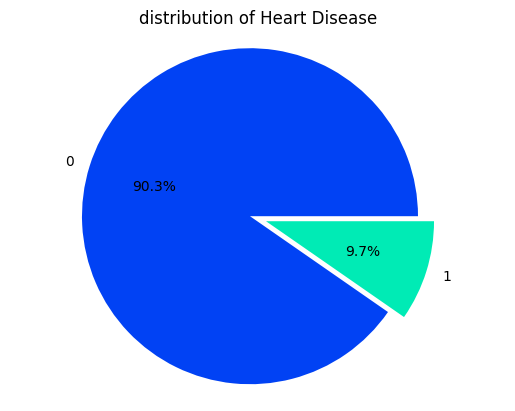

In [ ]:
heart_disease_column = df.HeartDisease.value_counts()

# pie chart for target column
plt.pie(heart_disease_column, labels = heart_disease_column.index, autopct="%1.1f%%", explode = [0,0.1], colors = ["#0142F4","#00EBB5"])
plt.title("distribution of Heart Disease")
plt.axis("equal")
plt.show()

# Resampling data


In [ ]:
df.HeartDisease.value_counts()

HeartDisease
0    4517
1     483
Name: count, dtype: int64

In [ ]:
resampling_strategy = {
    '0': RandomUnderSampler(sampling_strategy=0.5),  # Adjust the undersampling strategy
    '1': SMOTE(sampling_strategy=1)
}
resampler = Pipeline(steps=[('under', resampling_strategy['0']), ('over', resampling_strategy['1'])])
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
Counter(y_train_resampled)


Counter({0: 766, 1: 766})

In [ ]:
print("X_train after resampling :", X_train_resampled.shape)
print("y_train after resampling :", y_train_resampled.shape)

X_train after resampling : (1532, 95)
y_train after resampling : (1532,)


# Baseline


In [ ]:
dummy_classifier = DummyClassifier(strategy = 'most_frequent') 
dummy_classifier.fit(X_train, y_train) 
y_pred = dummy_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.9000


# Modeling

In [179]:
def train(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Greens',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

# Random forest

In [ ]:
rf_classifier = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=10, random_state=42)
)

In [ ]:
# Tiền xử lý dữ liệu
X = df['GeneralHealth']
y = df['HeartDisease']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vector hóa văn bản sử dụng CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vectorized, y_train)

# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test_vectorized)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Báo cáo đánh giá chi tiết
print(classification_report(y_test, y_pred))


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       900
           1       0.00      0.00      0.00       100

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000



# Naive Bayes

In [ ]:

# Tiền xử lý dữ liệu
X = df['GeneralHealth']
y = df['HeartDisease']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vector hóa văn bản sử dụng CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Huấn luyện mô hình Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vectorized, y_train)

# Dự đoán trên tập kiểm tra
y_pred = naive_bayes_model.predict(X_test_vectorized)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Báo cáo đánh giá chi tiết
print(classification_report(y_test, y_pred))


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       900
           1       0.00      0.00      0.00       100

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000



# Decision tree

In [180]:
# Loại bỏ các cột không phải số 
df_numeric = df.select_dtypes(include=['number'])
# Xử lý giá trị thiếu
df_numeric = df_numeric.fillna(0)  
# Chia dữ liệu thành tập HL và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(df_numeric.drop('HeartDisease', axis=1), df_numeric['HeartDisease'], test_size=0.2, random_state=42)
# Tạo và train mô hinh
max_depth_value = 5  # Giá trị càng lớn độ chính xác càng thấp
model_dt = DecisionTreeClassifier(max_depth=max_depth_value)
model_dt.fit(X_train, y_train)
# Dự đoán và đánh giá
predictions = model_dt.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.898
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       900
           1       0.00      0.00      0.00       100

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000



# The model with resampling

Cross Validation Score :  75.92%
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       900
           1       0.14      0.37      0.20       100

    accuracy                           0.71      1000
   macro avg       0.53      0.56      0.51      1000
weighted avg       0.84      0.71      0.76      1000



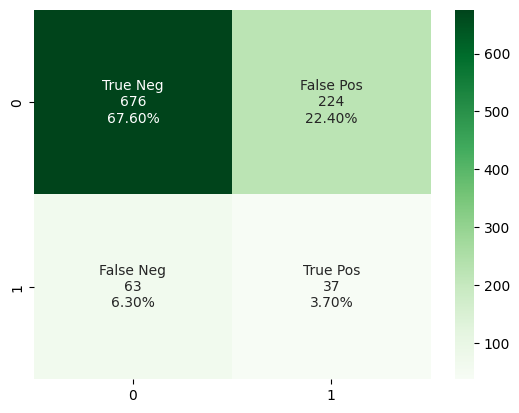

In [ ]:
train(rf_classifier, X_train_resampled, y_train_resampled, X_test, y_test)
model_evaluation(rf_classifier, X_test, y_test)

# The model without resampling

Cross Validation Score :  56.29%
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       900
           1       0.04      0.01      0.02       100

    accuracy                           0.88      1000
   macro avg       0.47      0.49      0.47      1000
weighted avg       0.81      0.88      0.84      1000



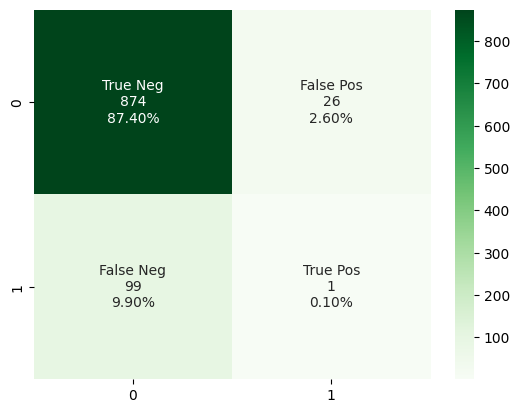

In [ ]:
train(rf_classifier, X_train, y_train, X_test, y_test)
model_evaluation(rf_classifier, X_test, y_test)

# Câu 3


## Build FFNN

In [ ]:

# Xây dựng mô hình FFNN
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Đánh giá mô hình
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy on test set:", accuracy)




Epoch 1/10


125/125 [==============================] - 1s 3ms/step - loss: 0.2990 - accuracy: 0.9013 - val_loss: 0.2597 - val_accuracy: 0.9030
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2604 - accuracy: 0.9020 - val_loss: 0.2643 - val_accuracy: 0.8950
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2567 - accuracy: 0.9010 - val_loss: 0.2748 - val_accuracy: 0.9030
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2389 - accuracy: 0.9100 - val_loss: 0.2594 - val_accuracy: 0.8950
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2343 - accuracy: 0.9100 - val_loss: 0.2625 - val_accuracy: 0.8980
Epoch 6/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2359 - accuracy: 0.9070 - val_loss: 0.2611 - val_accuracy: 0.8930
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2315 - accuracy: 0.9072 - val_loss: 0.2650 - val_accuracy: 0.8970
Epo

Mô hình được đánh giá trên tập kiểm thử (X_test, y_test) và kết quả được in ra màn hình. Độ chính xác trên tập kiểm thử là khoảng 89.4%.

# Recurrent Neural Network

In [ ]:
from tensorflow.keras.layers import SimpleRNN
# Assume X_train and X_test have shape (samples, timesteps)
# Reshape to add a third dimension (features) for SimpleRNN
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
model_rnn.add(Dense(units=64, activation='relu'))
model_rnn.add(Dense(units=1, activation='sigmoid'))

# Compile mô hình
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
model_rnn.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Đánh giá mô hình
accuracy_rnn = model_rnn.evaluate(X_test_reshaped, y_test)[1]
print("Accuracy on test set (RNN):", accuracy_rnn)


Epoch 1/10
125/125 [==============================] - 3s 13ms/step - loss: 0.3313 - accuracy: 0.9010 - val_loss: 0.3342 - val_accuracy: 0.9000
Epoch 2/10
125/125 [==============================] - 1s 11ms/step - loss: 0.3233 - accuracy: 0.9043 - val_loss: 0.3657 - val_accuracy: 0.9000
Epoch 3/10
125/125 [==============================] - 2s 13ms/step - loss: 0.3254 - accuracy: 0.9043 - val_loss: 0.3260 - val_accuracy: 0.9000
Epoch 4/10
125/125 [==============================] - 1s 11ms/step - loss: 0.3244 - accuracy: 0.9043 - val_loss: 0.3221 - val_accuracy: 0.9000
Epoch 5/10
125/125 [==============================] - 1s 11ms/step - loss: 0.3192 - accuracy: 0.9043 - val_loss: 0.3242 - val_accuracy: 0.9000
Epoch 6/10
125/125 [==============================] - 1s 12ms/step - loss: 0.3213 - accuracy: 0.9043 - val_loss: 0.3248 - val_accuracy: 0.9000
Epoch 7/10
125/125 [==============================] - 1s 11ms/step - loss: 0.3182 - accuracy: 0.9032 - val_loss: 0.3221 - val_accuracy: 0.9000

# Câu 4

### Tránh overfitting trên FFNN

#### Thêm dropout layer

In [ ]:
from tensorflow.keras.layers import Dropout

# Xây dựng mô hình FFNN với Dropout
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Đánh giá mô hình
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy on test set:", accuracy)


Epoch 1/10
125/125 [==============================] - 1s 3ms/step - loss: 0.5839 - accuracy: 0.8440 - val_loss: 0.3285 - val_accuracy: 0.9000
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3704 - accuracy: 0.8895 - val_loss: 0.3019 - val_accuracy: 0.9000
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.8980 - val_loss: 0.2751 - val_accuracy: 0.9000
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3036 - accuracy: 0.9028 - val_loss: 0.2640 - val_accuracy: 0.9000
Epoch 5/10
125/125 [==============================] - 0s 3ms/step - loss: 0.2938 - accuracy: 0.9018 - val_loss: 0.2602 - val_accuracy: 0.9000
Epoch 6/10
125/125 [==============================] - 0s 3ms/step - loss: 0.2783 - accuracy: 0.9028 - val_loss: 0.2584 - val_accuracy: 0.9000
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.9047 - val_loss: 0.2561 - val_accuracy: 0.9000
Epoch 

#### Early stopping

In [182]:
from tensorflow.keras.callbacks import EarlyStopping

# Xây dựng mô hình FFNN với Early Stopping
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Sử dụng Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Huấn luyện mô hình với Early Stopping
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Đánh giá mô hình
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy on test set:", accuracy)


Epoch 1/10
125/125 [==============================] - 1s 4ms/step - loss: 0.3587 - accuracy: 0.8917 - val_loss: 0.3543 - val_accuracy: 0.8750
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3288 - accuracy: 0.9028 - val_loss: 0.3303 - val_accuracy: 0.8860
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3258 - accuracy: 0.9022 - val_loss: 0.3282 - val_accuracy: 0.9000
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3218 - accuracy: 0.9000 - val_loss: 0.3308 - val_accuracy: 0.8950
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3168 - accuracy: 0.9020 - val_loss: 0.3257 - val_accuracy: 0.9000
Epoch 6/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3218 - accuracy: 0.9018 - val_loss: 0.3229 - val_accuracy: 0.9000
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 0.3136 - accuracy: 0.9040 - val_loss: 0.3699 - val_accuracy: 0.8660
Epoch 

### Tránh overfitting trên RNN

#### Thêm dropout layer

### Early stopping

In [187]:
from keras.layers import Dense, SimpleRNN, Dropout
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=128, activation='relu', input_shape=(X_train.shape[1], 1)))
model_rnn.add(Dropout(rate=0.2))  # Thêm lớp Dropout
model_rnn.add(Dense(units=64, activation='relu'))
model_rnn.add(Dense(units=1, activation='sigmoid'))

# Compile mô hình
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping để ngừng sớm khi không có cải thiện đủ lớn
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Huấn luyện mô hình
model_rnn.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# Đánh giá mô hình
accuracy_rnn = model_rnn.evaluate(X_test_reshaped, y_test)[1]
print("Accuracy on test set (RNN):", accuracy_rnn)


Epoch 1/10
125/125 [==============================] - 2s 6ms/step - loss: 0.3570 - accuracy: 0.8972 - val_loss: 0.3284 - val_accuracy: 0.9000
Epoch 2/10
125/125 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.9047 - val_loss: 0.3287 - val_accuracy: 0.9000
Epoch 3/10
125/125 [==============================] - 1s 5ms/step - loss: 0.3254 - accuracy: 0.9040 - val_loss: 0.3293 - val_accuracy: 0.9000
Epoch 4/10
125/125 [==============================] - 1s 5ms/step - loss: 0.3236 - accuracy: 0.9043 - val_loss: 0.3257 - val_accuracy: 0.9000
Epoch 5/10
125/125 [==============================] - 1s 4ms/step - loss: 0.3214 - accuracy: 0.9043 - val_loss: 0.3243 - val_accuracy: 0.9000
Epoch 6/10
125/125 [==============================] - 0s 4ms/step - loss: 0.3229 - accuracy: 0.9040 - val_loss: 0.3388 - val_accuracy: 0.9000
Epoch 7/10
125/125 [==============================] - 1s 4ms/step - loss: 0.3182 - accuracy: 0.9043 - val_loss: 0.3242 - val_accuracy: 0.9000
Epoch 

## Tránh overfitting trên Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

# Xây dựng và huấn luyện mô hình Random Forest với tìm kiếm tham số tốt nhất
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Dự đoán trên tập kiểm tra
y_pred = grid_search.predict(X_test_vectorized)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Báo cáo đánh giá chi tiết
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       900
           1       0.00      0.00      0.00       100

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000



# Tránh overfitting trên Naive Bayes


In [189]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Split the data
X = df['GeneralHealth']
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vector hóa dữ liệu 
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Xác định mô hình Naive Bayes
naive_bayes_model = MultinomialNB()

# Xác định các siêu tham số để điều chỉnh
param_grid = {'alpha': [0.1, 0.5, 1.0]}

# Sử dụng GridSearchCV để điều chỉnh siêu tham số bằng cross-validation
grid_search = GridSearchCV(naive_bayes_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)

# Lấy mẫu tốt nhất
best_model = grid_search.best_estimator_

# Đánh giá mô hình tốt nhất trên tập kiểm tra
y_pred = best_model.predict(X_test_vectorized)

# Dự đoán và đánh giá
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best Hyperparameters: {'alpha': 0.1}
Accuracy on Test Set: 0.9
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       900
           1       0.00      0.00      0.00       100

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000



# Tránh overfitting trên Decision Tree

In [190]:
from sklearn.tree import DecisionTreeClassifier

# Loại bỏ các cột không phải số
df_numeric = df.select_dtypes(include=['number'])

# Xử lý giá trị thiếu
df_numeric = df_numeric.fillna(0)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    df_numeric.drop('HeartDisease', axis=1),
    df_numeric['HeartDisease'],
    test_size=0.2,
    random_state=42
)

# Tạo và huấn luyện mô hình với điều chỉnh max_depth để tránh overfitting
max_depth_value = 5  # Thay đổi giá trị để kiểm soát overfitting
model_dt = DecisionTreeClassifier(max_depth=max_depth_value)
model_dt.fit(X_train, y_train)

# Dự đoán và đánh giá
predictions = model_dt.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print(classification_report(y_test, predictions))


Accuracy: 0.898
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       900
           1       0.00      0.00      0.00       100

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000



# Câu 5

In [191]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    df_numeric.drop('HeartDisease', axis=1),
    df_numeric['HeartDisease'],
    test_size=0.2,
    random_state=42
)

# Tạo và huấn luyện mô hình
model_dt = DecisionTreeClassifier(max_depth=5)
model_dt.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model_dt.predict(X_test)

# Phân tích trường hợp sai
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Thực hiện giải pháp (ví dụ: điều chỉnh max_depth)
model_dt_improved = DecisionTreeClassifier(max_depth=7)  # Điều chỉnh tham số
model_dt_improved.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra sau cải thiện
y_pred_improved = model_dt_improved.predict(X_test)

# Đánh giá lại mô hình sau cải thiện
conf_matrix_improved = confusion_matrix(y_test, y_pred_improved)
print("Improved Confusion Matrix:")
print(conf_matrix_improved)

# Improved Classification Report
print("Improved Classification Report:")
print(classification_report(y_test, y_pred_improved))


Confusion Matrix:
[[898   2]
 [100   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       900
           1       0.00      0.00      0.00       100

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000

Improved Confusion Matrix:
[[886  14]
 [ 96   4]]
Improved Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       900
           1       0.22      0.04      0.07       100

    accuracy                           0.89      1000
   macro avg       0.56      0.51      0.50      1000
weighted avg       0.83      0.89      0.85      1000

